In [1]:
# Zhang (2005, JF) – faithful minimal replication with tiny NN and operator-centric abstraction
# Dependencies: jax, numpy, sympy, matplotlib
# Author intent: smallest robust program to hit Tables II–III patterns

import os, math, dataclasses, functools, warnings
import numpy as np, jax.numpy as jnp
from jax import random, grad, value_and_grad, vmap
import sympy as sp
import matplotlib.pyplot as plt

# ------------------------------- FAST MODE -------------------------------
FAST = bool(int(os.getenv("NOTEBOOK_FAST", "1")))
def fast(slow, fast_): return fast_ if FAST else slow
def set_seed(seed=0):  return random.PRNGKey(seed)

# ------------------------- ECONOMY (Zhang 2005) --------------------------
# Canonical monthly parameters; Zhang (2005) uses convex adjustment costs and aggregate risk.  # :contentReference[oaicite:16]{index=16}
alpha, delta = 0.30, 0.01
rho_x, sig_x = 0.951**(1/3), 0.007/3.0
eta = 0.50
rho_z, sig_z = 0.97, 0.10
theta_p, theta_m = 15.0, 150.0
f, xbar = 0.0365, -5.70

# Target annual moments (rf mean/vol, SDF Sharpe) from literature summaries
T_rf_mean, T_rf_vol, T_Sharpe = 0.018, 0.030, 0.43

# ----------------------------- QUADRATURE --------------------------------
# Probabilists' Hermite E: weight exp(-x^2/2); to get E[f(Z)], Z~N(0,1), divide weights by sqrt(2π).  # :contentReference[oaicite:17]{index=17}
XI_X, WI_X = np.polynomial.hermite_e.hermegauss(11)
XI_Z, WI_Z = np.polynomial.hermite_e.hermegauss(7)
XI_X, WI_X = jnp.array(XI_X), jnp.array(WI_X)/jnp.sqrt(2*jnp.pi)
XI_Z, WI_Z = jnp.array(XI_Z), jnp.array(WI_Z)/jnp.sqrt(2*jnp.pi)

# ----------------------------- SDF / PRICING -----------------------------
def sdf_M(beta, g0, g1, x, xp):
    gam = g0 + g1*(x - xbar)
    return jnp.exp(jnp.log(beta) + gam*(x - xp))

def sdf_moments_ann(beta, g0, g1):
    sig_stat = sig_x / jnp.sqrt(1 - rho_x**2)
    xs = xbar + sig_stat*XI_X
    gam = g0 + g1*(xs - xbar)
    mu_m = gam*(1 - rho_x)*(xs - xbar)
    sig_m = sig_x*gam
    rf = (1/beta)*jnp.exp(-mu_m - 0.5*sig_m**2) - 1.0
    S  = jnp.sqrt(jnp.exp(sig_m**2) - 1.0)
    m_rf = (WI_X*rf).sum()
    v_rf = jnp.sqrt((WI_X*(rf - m_rf)**2).sum())
    Sbar = (WI_X*S).sum()
    return 12*m_rf, jnp.sqrt(12)*v_rf, jnp.sqrt(12)*Sbar

def calibrate_sdf(th0=jnp.array([0.994, 50.0, -1000.0]), lr=3e-3, steps=None):
    steps = steps or fast(250, 80)
    tgt = jnp.array([T_rf_mean, T_rf_vol, T_Sharpe])
    def loss(th):
        beta=jnp.clip(th[0],0.9,0.9999); g0, g1 = th[1], th[2]
        m=jnp.array(sdf_moments_ann(beta,g0,g1))
        return jnp.sum((m - tgt)**2)
    th = th0
    for _ in range(steps): th = th - lr*grad(loss)(th)
    beta=float(jnp.clip(th[0],0.9,0.9999)); g0=float(th[1]); g1=float(th[2])
    return beta, g0, g1

beta, g0, g1 = calibrate_sdf()

# ----------------------------- VALUE NET ---------------------------------
def init_mlp(key, sizes=(4,32,16,1)):
    keys = random.split(key, len(sizes)-1); params=[]
    for k,(m,n) in zip(keys, zip(sizes[:-1],sizes[1:])):
        W = random.normal(k,(m,n))*jnp.sqrt(2.0/m); b=jnp.zeros((n,))
        params.append((W,b))
    return params

def mlp_forward(p, x):
    h=x
    for (W,b) in p[:-1]: h=jnp.tanh(h@W+b)
    W,b=p[-1]; return (h@W+b).squeeze()

def v_and_dvk(p, X):  # vectorized: value and ∂V/∂K
    v = vmap(lambda x: mlp_forward(p,x))(X)
    dvk = vmap(lambda x: grad(lambda xx: mlp_forward(p,xx))(x))(X)[:,0]
    return v, dvk

# --------------------------- ADJUSTMENT / POLICY -------------------------
def invest_rate_from_q(q):  # s = i/k
    th=jnp.where(q-1.0>=0.0, theta_p, theta_m)          # costly reversibility: θ+ vs θ-  # :contentReference[oaicite:18]{index=18}
    return jnp.clip((q-1.0)/th, -0.5, 0.5)

# --------------------------- EXPECTATION OPERATOR -------------------------
def gh_expect(beta,g0,g1, X_now, f_next):
    K,Z,X,P = X_now[:,0], X_now[:,1], X_now[:,2], X_now[:,3]
    mu_x = (1-rho_x)*xbar + rho_x*X[:,None]
    XP = mu_x + sig_x*XI_X[None,:]
    ZP = (rho_z*Z)[:,None] + sig_z*XI_Z[None,:]
    Mt1 = jnp.exp(jnp.log(beta) + (g0+g1*(X-xbar))[:,None]*(X[:,None]-XP))
    W = WI_X[None,:,None]*WI_Z[None,None,:]
    val = f_next(XP,ZP)
    return jnp.sum(W*(Mt1[:,:,None]*val), axis=(1,2))

# ------------------------------- OPTIMIZER --------------------------------
@dataclasses.dataclass
class OptState:
    m: list; v: list; t: int

def adamw_init(params):
    m = [(jnp.zeros_like(W), jnp.zeros_like(b)) for (W,b) in params]
    v = [(jnp.zeros_like(W), jnp.zeros_like(b)) for (W,b) in params]
    return OptState(m,v,0)

def adamw_update(params, grads, opt, lr, wd=1e-4, b1=0.9, b2=0.999, eps=1e-8):
    t = opt.t + 1
    new_m, new_v, new_params = [], [], []
    for (W,b), (gW,gb), (mW,mb), (vW,vb) in zip(params, grads, opt.m, opt.v):
        mW = b1*mW + (1-b1)*gW; vW = b2*vW + (1-b2)*(gW*gW)
        mb = b1*mb + (1-b1)*gb; vb = b2*vb + (1-b2)*(gb*gb)
        mWh = mW/(1-b1**t); vWh = vW/(1-b2**t)
        mbh = mb/(1-b1**t); vbh = vb/(1-b2**t)
        W = W - lr*(mWh/(jnp.sqrt(vWh)+eps) + wd*W)   # AdamW  # :contentReference[oaicite:19]{index=19}
        b = b - lr*(mbh/(jnp.sqrt(vbh)+eps) + 0.0*b)
        new_m.append((mW,mb)); new_v.append((vW,vb)); new_params.append((W,b))
    return new_params, OptState(new_m, new_v, t)

def clip_like(dw, c=0.6):
    n=jnp.linalg.norm(dw); s=jnp.minimum(1.0, c/(n+1e-8)); return dw*s

def l2(tree): return jnp.sqrt(sum((dW*dW).sum() + (db*db).sum() for (dW, db) in tree))

def sam_step(params, key, a, lr=3e-4, rho=0.05, clip=0.6, B=None, opt=None):
    # SAM (sharpness-aware) step with Huber Bellman loss; adversarial radius rho.  # :contentReference[oaicite:20]{index=20}
    B = B or fast(256,128)
    d1,d2,d3,d4 = a
    k1,k2,k3,k4 = random.split(key,4)
    K = jnp.exp(random.uniform(k1,(B,),minval=-0.3,maxval=0.3))
    X = xbar + random.normal(k2,(B,))*(sig_x/jnp.sqrt(1-rho_x**2))
    Z = random.normal(k3,(B,))*(sig_z/jnp.sqrt(1-rho_z**2))
    P = jnp.zeros((B,))
    S = jnp.stack([K,Z,X,P],1)
    sigk = jnp.std(jnp.log(K))

    def bellman(p0):
        def EVk(Kp, XP, ZP, Pt, Xt, sigk_t):
            PP = d1 + d2*Pt[:,None,None] + d3*(Xt[:,None,None]-xbar) + d4*sigk_t
            IN = jnp.stack([
                jnp.broadcast_to(Kp[:,None,None], (Kp.shape[0], XP.shape[1], ZP.shape[1])),
                jnp.broadcast_to(ZP[:,None,:],    (Kp.shape[0], XP.shape[1], ZP.shape[1])),
                jnp.broadcast_to(XP[:,:,None],    (Kp.shape[0], XP.shape[1], ZP.shape[1])),
                jnp.broadcast_to(PP,              (Kp.shape[0], XP.shape[1], ZP.shape[1]))
            ],axis=3).reshape(-1,4)
            return v_and_dvk(p0, IN)[1].reshape(Kp.shape[0], XP.shape[1], ZP.shape[1])

        def EV(Kp, XP, ZP, Pt, Xt, sigk_t):
            PP = d1 + d2*Pt[:,None,None] + d3*(Xt[:,None,None]-xbar) + d4*sigk_t
            IN = jnp.stack([
                jnp.broadcast_to(Kp[:,None,None], (Kp.shape[0], XP.shape[1], ZP.shape[1])),
                jnp.broadcast_to(ZP[:,None,:],    (Kp.shape[0], XP.shape[1], ZP.shape[1])),
                jnp.broadcast_to(XP[:,:,None],    (Kp.shape[0], XP.shape[1], ZP.shape[1])),
                jnp.broadcast_to(PP,              (Kp.shape[0], XP.shape[1], ZP.shape[1]))
            ],axis=3).reshape(-1,4)
            return vmap(lambda x: mlp_forward(p0,x))(IN).reshape(Kp.shape[0], XP.shape[1], ZP.shape[1])

        pi = jnp.exp(X+Z+P)*(K**alpha) - f
        q0 = gh_expect(beta,g0,g1,S, lambda XP,ZP: EVk(((1-delta)*K), XP, ZP, P, X, sigk))
        s  = invest_rate_from_q(q0)
        i  = s*K; th=jnp.where(s>=0, theta_p, theta_m); adj=0.5*th*s*s*K
        d  = pi - i - adj
        Kp = (1-delta+s)*K
        EVc = gh_expect(beta,g0,g1,S, lambda XP,ZP: EV(Kp, XP, ZP, P, X, sigk))
        v0,_= v_and_dvk(p0, S)
        Bell = v0 - (d + EVc)
        hub = 0.1*(jnp.sqrt(1+(Bell/0.1)**2)-1)                     # Huber
        foc = s*th - (q0-1.0)                                        # q-1 = θ s
        reg = 1e-6*sum((W*W).sum() for (W,_) in p0)
        return jnp.mean(hub) + 5e-4*jnp.mean(foc*foc) + reg

    L, g = value_and_grad(bellman)(params)
    gnorm = l2(g)+1e-8
    params_adv = [(W+rho*dW/gnorm, b+rho*db/gnorm) for (W,b),(dW,db) in zip(params,g)]
    _, g2 = value_and_grad(bellman)(params_adv)
    upd = [(clip_like(dW, clip), clip_like(db, clip)) for (dW,db) in g2]
    newp, opt = adamw_update(params, upd, opt, lr=lr, wd=1e-4)
    return newp, float(L), opt

# ------------------------------ PRICE LAW (OLS) ---------------------------
def fit_price_law(params, a, T=None, N=None, seed=0):
    T = T or fast(400,120); N = N or fast(3000,800)
    d1,d2,d3,d4 = a
    key = random.PRNGKey(seed)
    Z = random.normal(key,(N,))*(sig_z/jnp.sqrt(1-rho_z**2))
    X = jnp.ones((T,))*xbar; eps = random.normal(random.fold_in(key,1),(T,))*sig_x
    for t in range(1,T): X = X.at[t].set((1-rho_x)*xbar + rho_x*X[t-1] + eps[t])
    K = jnp.exp(random.uniform(random.fold_in(key,2),(N,),minval=-0.1,maxval=0.1))
    P = jnp.zeros((T,)); sigks=[]; Ps=[]; Xs=[]; Pps=[]
    for t in range(T-1):
        Pt = P[t]; sigk = float(jnp.std(jnp.log(K)))
        S_now = jnp.stack([K, Z, jnp.full_like(K, X[t]), jnp.full_like(K, Pt)],1)
        def EVk_at(Kp, XP, ZP):
            PP = d1 + d2*Pt + d3*(X[t]-xbar) + d4*sigk
            IN = jnp.stack([
                jnp.broadcast_to(Kp[:,None,None], (Kp.shape[0], XP.shape[1], ZP.shape[1])),
                jnp.broadcast_to(ZP[:,None,:],    (Kp.shape[0], XP.shape[1], ZP.shape[1])),
                jnp.broadcast_to(XP[:,:,None],    (Kp.shape[0], XP.shape[1], ZP.shape[1])),
                jnp.broadcast_to(PP,              (Kp.shape[0], XP.shape[1], ZP.shape[1]))
            ],axis=3).reshape(-1,4)
            return v_and_dvk(params, IN)[1].reshape(Kp.shape[0], XP.shape[1], ZP.shape[1])
        q = gh_expect(beta,g0,g1, S_now, lambda XP,ZP: EVk_at(((1-delta)*K), XP, ZP))
        s = invest_rate_from_q(q); i=s*K
        th=jnp.where(s>=0,theta_p,theta_m); adj=0.5*th*s*s*K
        pi=jnp.exp(X[t]+Z+Pt)*(K**alpha)-f
        K = (1-delta+s)*K
        Z = rho_z*Z + sig_z*random.normal(random.fold_in(key,100+t),(N,))
        Pps.append(float(d1 + d2*Pt + d3*(X[t]-xbar) + d4*sigk))
        P = P.at[t+1].set(Pps[-1])
        Ps.append(float(Pt)); Xs.append(float(X[t])); sigks.append(float(sigk))
    Xreg = jnp.column_stack([jnp.ones(len(Ps)), jnp.array(Ps), jnp.array(Xs)-xbar, jnp.array(sigks)])
    y    = jnp.array(Pps)
    lam=1e-6
    a_new = jnp.linalg.solve(Xreg.T@Xreg + lam*jnp.eye(4), Xreg.T@y)
    yhat = Xreg@a_new; R2 = 1 - jnp.sum((y-yhat)**2)/jnp.sum((y-yhat.mean())**2)
    return tuple(map(float,a_new)), float(R2)

# ------------------------------- TRAINING ---------------------------------
def train(outer=None, inner=None, seed=1):
    outer = outer or fast(3,1); inner = inner or fast(250,60)
    key = set_seed(seed)
    params = init_mlp(key)
    a = (0.0, 0.98, -0.12, 0.004)
    opt = adamw_init(params)
    for it in range(outer):
        for t in range(inner):
            key = random.fold_in(key, it*1000+t)
            params, L, opt = sam_step(params, key, a, lr=3e-4, rho=0.05, clip=0.6, opt=opt)
        a, R2 = fit_price_law(params, a, T=fast(400,120), N=fast(3000,800), seed=42+it)
        print(f"[Outer {it}] Bellman≈{L:.3e} ; price law={tuple(round(x,4) for x in a)} ; R2={R2:.6f}")
        # R^2 is a weak accuracy measure for aggregates; keep only as sanity check.  # :contentReference[oaicite:21]{index=21}
        if R2>0.999: break
    return params, a

params, a = train()

# ------------------------------- SYMPY CHECK ------------------------------
s,q,th=sp.symbols('s q th', real=True)
obj = q*s - s - sp.Rational(1,2)*th*s**2
s_star=sp.simplify(sp.diff(obj,s))
assert sp.simplify(sp.solve(sp.Eq(s_star,0), s)[0] - (q-1)/th) == 0

# --------------------------- SIMULATION & TABLES --------------------------
def one_step_policy_and_div(params, state, a):
    """Given S_t=(K,Z,X,P), compute s_t, i_t, d_t, K_{t+1} and P_{t+1} under model-consistent q"""
    K,Z,X,P = state
    d1,d2,d3,d4=a
    # q_t
    S_now = jnp.stack([K[None],Z[None],X[None],P[None]],axis=1)
    def EVk_at(Kp, XP, ZP):
        PP = d1 + d2*P + d3*(X-xbar) + d4*float(jnp.std(jnp.log(K[None]+1e-8)))  # local sig_k proxy
        IN = jnp.stack([
            jnp.broadcast_to(Kp[:,None,None], (Kp.shape[0], XP.shape[1], ZP.shape[1])),
            jnp.broadcast_to(ZP[:,None,:],    (Kp.shape[0], XP.shape[1], ZP.shape[1])),
            jnp.broadcast_to(XP[:,:,None],    (Kp.shape[0], XP.shape[1], ZP.shape[1])),
            jnp.broadcast_to(PP,              (Kp.shape[0], XP.shape[1], ZP.shape[1]))
        ],axis=3).reshape(-1,4)
        return v_and_dvk(params, IN)[1].reshape(Kp.shape[0], XP.shape[1], ZP.shape[1])
    q = gh_expect(beta,g0,g1, S_now, lambda XP,ZP: EVk_at(((1-delta)*K[None]), XP, ZP))[0]
    s = invest_rate_from_q(q); i = s*K
    th = theta_p if s>=0 else theta_m
    adj = 0.5*th*(s*s)*K
    pi  = jnp.exp(X+Z+P)*(K**alpha) - f
    d   = pi - i - adj
    Kp  = (1-delta+s)*K
    P_next = d1 + d2*P + d3*(X-xbar) + d4*float(abs(jnp.log(K+1e-8)-jnp.log(Kp+1e-8))) # simple vol proxy
    return float(s), float(i), float(d), float(Kp), float(P_next)

def simulate_panel(params, a, T=None, N=None, seed=99):
    T = T or fast(900,200); N = N or fast(5000,1500)
    d1,d2,d3,d4=a
    key = random.PRNGKey(seed)
    Z = random.normal(key,(N,))*(sig_z/jnp.sqrt(1-rho_z**2))
    X = jnp.ones((T,))*xbar; eps = random.normal(random.fold_in(key,1),(T,))*sig_x
    for t in range(1,T): X = X.at[t].set((1-rho_x)*xbar + rho_x*X[t-1] + eps[t])
    K = jnp.exp(random.uniform(random.fold_in(key,2),(N,),minval=-0.1,maxval=0.1))
    P = jnp.zeros((T,))
    R_firms=[]; MktW=[]; bm_list=[]; HML=[]; DecileR=[[] for _ in range(10)]
    size_bins=None; decile_bins=None
    for t in range(T-2):  # we need t and t+1 objects to compute d_{t+1}
        Pt = P[t]
        # q_t and policy at t
        S_now = jnp.stack([K, Z, jnp.full_like(K, X[t]), jnp.full_like(K, Pt)],1)
        sigk = float(jnp.std(jnp.log(K)))
        def EVk_at(Kp, XP, ZP):
            PP = d1 + d2*Pt + d3*(X[t]-xbar) + d4*sigk
            IN = jnp.stack([
                jnp.broadcast_to(Kp[:,None,None], (Kp.shape[0], XP.shape[1], ZP.shape[1])),
                jnp.broadcast_to(ZP[:,None,:],    (Kp.shape[0], XP.shape[1], ZP.shape[1])),
                jnp.broadcast_to(XP[:,:,None],    (Kp.shape[0], XP.shape[1], ZP.shape[1])),
                jnp.broadcast_to(PP,              (Kp.shape[0], XP.shape[1], ZP.shape[1]))
            ],axis=3).reshape(-1,4)
            return v_and_dvk(params, IN)[1].reshape(Kp.shape[0], XP.shape[1], ZP.shape[1])
        q  = gh_expect(beta,g0,g1, S_now, lambda XP,ZP: EVk_at(((1-delta)*K), XP, ZP))
        s  = invest_rate_from_q(q); i=s*K
        th=jnp.where(s>=0,theta_p,theta_m); adj=0.5*th*s*s*K
        d  = jnp.exp(X[t]+Z+Pt)*(K**alpha) - f - i - adj
        V_cum,_ = v_and_dvk(params, S_now)
        V_ex   = V_cum - d  # ex-div price at t

        # evolve to t+1 states and policy to get d_{t+1}
        Kp = (1-delta+s)*K
        Zp = rho_z*Z + sig_z*random.normal(random.fold_in(key,100+t),(N,))
        Xp = (1-rho_x)*xbar + rho_x*X[t] + eps[t]
        P_next = d1 + d2*Pt + d3*(X[t]-xbar) + d4*sigk
        S_next = jnp.stack([Kp, Zp, jnp.full_like(Kp, Xp), jnp.full_like(Kp, P_next)],1)

        # dividend at t+1 under model-consistent s_{t+1}
        def EVk_next(Kpp, XP, ZP):
            PP = d1 + d2*P_next + d3*(Xp-xbar) + d4*float(jnp.std(jnp.log(Kp)))
            IN = jnp.stack([
                jnp.broadcast_to(Kpp[:,None,None], (Kpp.shape[0], XP.shape[1], ZP.shape[1])),
                jnp.broadcast_to(ZP[:,None,:],     (Kpp.shape[0], XP.shape[1], ZP.shape[1])),
                jnp.broadcast_to(XP[:,:,None],     (Kpp.shape[0], XP.shape[1], ZP.shape[1])),
                jnp.broadcast_to(PP,               (Kpp.shape[0], XP.shape[1], ZP.shape[1]))
            ],axis=3).reshape(-1,4)
            return v_and_dvk(params, IN)[1].reshape(Kpp.shape[0], XP.shape[1], ZP.shape[1])
        qn = gh_expect(beta,g0,g1, S_next, lambda XP,ZP: EVk_next(((1-delta)*Kp), XP, ZP))
        sn = invest_rate_from_q(qn); inxt=sn*Kp
        thn=jnp.where(sn>=0,theta_p,theta_m); adjn=0.5*thn*sn*sn*Kp
        dn = jnp.exp(Xp+Zp+P_next)*(Kp**alpha) - f - inxt - adjn

        V_cum_next,_ = v_and_dvk(params, S_next)
        V_ex_next = V_cum_next - dn*0.0  # ex-div at start of t+1 (before paying dn)

        # Correct equity returns: (P_{t+1} + D_{t+1})/P_t - 1
        R = (V_ex_next + dn) / (V_ex + 1e-8) - 1.0
        R_firms.append(np.array(R))

        # Book-to-market and weights
        mktcap = np.array(V_ex); book = np.array(K)
        bm = book/(mktcap+1e-8)
        bm_list.append(bm); MktW.append(mktcap/np.sum(mktcap+1e-8))

        # Annual sorts for HML & BM deciles (2×3 HML, 10 deciles)
        if t % 12 == 0:
            size_q = np.quantile(mktcap,[0.3,0.7])
            bm_q = np.quantile(bm, np.linspace(0.1,0.9,9))
            size_bins = (size_q[0], size_q[1]); decile_bins = bm_q

        if decile_bins is not None:
            idx = np.digitize(bm, decile_bins, right=True)
            for k_dec in range(10):
                mask = (idx==k_dec)
                w = mktcap[mask]; w = w/(w.sum()+1e-8)
                DecileR[k_dec].append(float(np.sum(w*R[mask]) if np.any(mask) else 0.0))
            small = mktcap < size_bins[0]; big = mktcap > size_bins[1]
            low = bm < np.quantile(bm,0.3); high = bm > np.quantile(bm,0.7)
            def vw(mask):
                w=mktcap[mask]; w=w/(w.sum()+1e-8)
                return float(np.sum(w*R[mask]) if np.any(mask) else 0.0)
            HML.append(0.5*(vw(small & high)+vw(big & high)) - 0.5*(vw(small & low)+vw(big & low)))

        # update states
        K, Z = Kp, Zp
        P = P.at[t+1].set(P_next)

    R_firms = np.array(R_firms)            # [T-2, N]
    W_mkt   = np.array(MktW)
    R_mkt   = np.sum(W_mkt*R_firms, axis=1)

    rf_m, rf_v, Sharpe = sdf_moments_ann(beta,g0,g1)
    indiv_vol = np.std(R_firms, axis=0).mean()
    industry_mean, industry_vol = 12*np.mean(R_mkt), math.sqrt(12)*np.std(R_mkt)
    bm_arr = np.array(bm_list)
    bm_mean, bm_vol = np.mean(bm_arr), np.std(bm_arr)

    HML = np.array(HML)
    deciles = [np.array(DecileR[k]) for k in range(10)]
    def beta_of(series, mkt):
        x = mkt - np.mean(mkt); y = series - np.mean(series); return float((x@y)/((x@x)+1e-8))
    betas = [beta_of(d, R_mkt) for d in deciles if len(d)>0]
    while len(betas) < 10: betas.append(np.nan)

    # Investment distribution diagnostics (costly reversibility)
    last_s_snapshot = s  # last s from loop; indicative
    disinv_share = float(np.mean((R_firms[0]*0+1) * (last_s_snapshot<0)))  # quick proxy

    return dict(
        rf_mean_ann=float(rf_m), rf_vol_ann=float(rf_v), Sharpe_ann=float(Sharpe),
        industry_mean_ann=float(industry_mean), industry_vol_ann=float(industry_vol),
        indiv_vol_month=float(indiv_vol), bm_mean=float(bm_mean), bm_vol=float(bm_vol),
        HML=HML, Deciles=deciles, R_mkt=R_mkt, Betas=betas, PriceLaw=a,
        disinv_share=float(disinv_share)
    )

res = simulate_panel(params, a)

# ----------------------------- PRINT TABLES -------------------------------
print("\n[Table II approx]")
print("rf_mean=%.3f (target 0.018), rf_vol=%.3f (0.030), Sharpe=%.2f (0.43)" %
      (res["rf_mean_ann"], res["rf_vol_ann"], res["Sharpe_ann"]))
print("Market mean=%.2f (≈0.12–0.14 ann), vol=%.2f (≈0.23–0.28 ann)" %
      (res["industry_mean_ann"], res["industry_vol_ann"]))
print("Avg indiv. vol (monthly)=%.3f" % res["indiv_vol_month"])
print("BM mean=%.2f (≈0.67), BM vol=%.2f (≈0.23)" %
      (res["bm_mean"], res["bm_vol"]))
print("Disinvestment share (proxy)=%.3f (small under costly reversibility)" % res["disinv_share"])  # :contentReference[oaicite:22]{index=22}

print("\n[Table III approx]")
hml_ann_mean = 12*np.mean(res["HML"]) if len(res["HML"])>0 else np.nan
hml_ann_vol  = math.sqrt(12)*np.std(res["HML"]) if len(res["HML"])>0 else np.nan
print("HML mean=%.3f, HML vol=%.3f" % (hml_ann_mean, hml_ann_vol))
for i,d in enumerate(res["Deciles"]):
    if len(d)>0:
        print("Decile %d: mean=%.3f, vol=%.3f, beta=%.2f" %
            (i+1, 12*np.mean(d), math.sqrt(12)*np.std(d), res["Betas"][i]))

# ----------------------------- PLOTS & DIAGS ------------------------------
def diagnostic_plots(res, params, outdir=None):
    outdir = outdir or os.getcwd()
    # i/k histogram from a stationary batch
    N = fast(3000,1000); key=set_seed(7)
    K = jnp.exp(random.uniform(random.fold_in(key,2),(N,),minval=-0.3,maxval=0.3))
    Z = random.normal(key,(N,))*(sig_z/jnp.sqrt(1-rho_z**2))
    X = xbar + random.normal(random.fold_in(key,1),(N,))*(sig_x/jnp.sqrt(1-rho_x**2))
    P = jnp.zeros((N,))
    S = jnp.stack([K,Z,X,P],1)
    def EVk_at(Kp, XP, ZP):
        d1,d2,d3,d4 = res["PriceLaw"]
        PP = d1 + d2*0.0 + d3*(X.mean()-xbar) + d4*float(jnp.std(jnp.log(K)))
        IN = jnp.stack([
            jnp.broadcast_to(Kp[:,None,None], (Kp.shape[0], XP.shape[1], ZP.shape[1])),
            jnp.broadcast_to(ZP[:,None,:],    (Kp.shape[0], XP.shape[1], ZP.shape[1])),
            jnp.broadcast_to(XP[:,:,None],    (Kp.shape[0], XP.shape[1], ZP.shape[1])),
            jnp.broadcast_to(PP,              (Kp.shape[0], XP.shape[1], ZP.shape[1]))
        ],axis=3).reshape(-1,4)
        return v_and_dvk(params, IN)[1].reshape(Kp.shape[0], XP.shape[1], ZP.shape[1])
    q = gh_expect(beta,g0,g1, S, lambda XP,ZP: EVk_at(((1-delta)*K), XP, ZP))
    s = np.array(invest_rate_from_q(q))
    plt.figure(); plt.hist(s, bins=50); plt.title("Histogram of i/k"); plt.tight_layout()
    plt.savefig(os.path.join(outdir,"ik_hist.png")); plt.close()

    # HML series
    if len(res["HML"])>0:
        plt.figure(); plt.plot(res["HML"]); plt.title("HML monthly"); plt.tight_layout()
        plt.savefig(os.path.join(outdir,"HML_series.png")); plt.close()

    # BM decile annualized means
    means = [12*np.mean(d) if len(d)>0 else np.nan for d in res["Deciles"]]
    plt.figure(); plt.bar(range(1,11), means); plt.title("BM deciles: annualized means"); plt.tight_layout()
    plt.savefig(os.path.join(outdir,"BM_decile_means.png")); plt.close()

diagnostic_plots(res, params)

# FOC residual snapshot
def foc_residual_snapshot(params, a, B=None, seed=123):
    B = B or fast(4000,1500)
    d1,d2,d3,d4 = a
    key=set_seed(seed); k1,k2,k3 = random.split(key,3)
    K = jnp.exp(random.uniform(k1,(B,),minval=-0.3,maxval=0.3))
    X = xbar + random.normal(k2,(B,))*(sig_x/jnp.sqrt(1-rho_x**2))
    Z = random.normal(k3,(B,))*(sig_z/jnp.sqrt(1-rho_z**2))
    P = jnp.zeros((B,)); S=jnp.stack([K,Z,X,P],1)
    def EVk_at(Kp, XP, ZP):
        PP = d1 + d2*0.0 + d3*(X[:,None,None]-xbar) + d4*float(jnp.std(jnp.log(K)))
        IN = jnp.stack([
            jnp.broadcast_to(Kp[:,None,None], (Kp.shape[0], XP.shape[1], ZP.shape[1])),
            jnp.broadcast_to(ZP[:,None,:],    (Kp.shape[0], XP.shape[1], ZP.shape[1])),
            jnp.broadcast_to(XP[:,:,None],    (Kp.shape[0], XP.shape[1], ZP.shape[1])),
            jnp.broadcast_to(PP,              (Kp.shape[0], XP.shape[1], ZP.shape[1]))
        ],axis=3).reshape(-1,4)
        return v_and_dvk(params, IN)[1].reshape(Kp.shape[0], XP.shape[1], ZP.shape[1])
    q = gh_expect(beta,g0,g1, S, lambda XP,ZP: EVk_at(((1-delta)*K), XP, ZP))
    s = invest_rate_from_q(q); th=jnp.where(s>=0,theta_p,theta_m)
    foc = q-1.0 - th*s
    return np.array(foc)

foc = foc_residual_snapshot(params, a)
print("[Diagnostics] FOC residual mean=%.3e, std=%.3e" % (foc.mean(), foc.std()))

# Den Haan–Marcet JT proxy on FOC residuals × instruments [1, X̄, Z̄]
def den_haan_marcet_stat(params, a, T=None, N=None, seed=202):
    T = T or fast(600,180); N = N or fast(2000,800)
    d1,d2,d3,d4 = a; key=set_seed(seed)
    Z = random.normal(key,(N,))*(sig_z/jnp.sqrt(1-rho_z**2))
    X = jnp.ones((T,))*xbar; eps = random.normal(random.fold_in(key,1),(T,))*sig_x
    for t in range(1,T): X = X.at[t].set((1-rho_x)*xbar + rho_x*X[t-1] + eps[t])
    K = jnp.exp(random.uniform(random.fold_in(key,2),(N,),minval=-0.1,maxval=0.1))
    P = jnp.zeros((T,))
    M=[]; W=[]
    for t in range(T-1):
        Pt = P[t]; sigk=float(jnp.std(jnp.log(K)))
        S_now = jnp.stack([K,Z,jnp.full_like(K,X[t]), jnp.full_like(K,Pt)],1)
        def EVk_at(Kp, XP, ZP):
            PP = d1 + d2*Pt + d3*(X[t]-xbar) + d4*sigk
            IN = jnp.stack([
                jnp.broadcast_to(Kp[:,None,None], (Kp.shape[0], XP.shape[1], ZP.shape[1])),
                jnp.broadcast_to(ZP[:,None,:],    (Kp.shape[0], XP.shape[1], ZP.shape[1])),
                jnp.broadcast_to(XP[:,:,None],    (Kp.shape[0], XP.shape[1], ZP.shape[1])),
                jnp.broadcast_to(PP,              (Kp.shape[0], XP.shape[1], ZP.shape[1]))
            ],axis=3).reshape(-1,4)
            return v_and_dvk(params, IN)[1].reshape(Kp.shape[0], XP.shape[1], ZP.shape[1])
        q = gh_expect(beta,g0,g1, S_now, lambda XP,ZP: EVk_at(((1-delta)*K), XP, ZP))
        s = invest_rate_from_q(q); th=jnp.where(s>=0,theta_p,theta_m)
        foc = q-1.0 - th*s
        zbar = float(jnp.mean(Z))
        instr = np.array([1.0, float(X[t]), zbar])
        M.append(instr*np.mean(np.array(foc)))
        W.append(np.outer(instr, instr))
        K = (1-delta+s)*K
        Z = rho_z*Z + sig_z*random.normal(random.fold_in(key,100+t),(N,))
        P = P.at[t+1].set(d1 + d2*Pt + d3*(X[t]-xbar) + d4*sigk)
    M = np.mean(np.array(M), axis=0)
    W = np.mean(np.array(W), axis=0) + 1e-8*np.eye(3)
    JT = float(len(M)*M.T@np.linalg.inv(W)@M)
    return JT

JT = den_haan_marcet_stat(params, a)
print("[Diagnostics] DHM statistic (proxy) = %.3f (lower is better)" % JT)


[Outer 0] Bellman≈1.731e-03 ; price law=(-0.0, 0.98, -0.12, 0.004) ; R2=1.000000

[Table II approx]
rf_mean=0.018 (target 0.018), rf_vol=0.028 (0.030), Sharpe=0.41 (0.43)
Market mean=-1.13 (≈0.12–0.14 ann), vol=0.03 (≈0.23–0.28 ann)
Avg indiv. vol (monthly)=0.020
BM mean=0.44 (≈0.67), BM vol=0.61 (≈0.23)
Disinvestment share (proxy)=1.000 (small under costly reversibility)

[Table III approx]
HML mean=-0.106, HML vol=0.086
Decile 1: mean=-1.117, vol=0.017, beta=0.58
Decile 2: mean=-1.130, vol=0.028, beta=0.90
Decile 3: mean=-1.134, vol=0.035, beta=1.05
Decile 4: mean=-1.144, vol=0.042, beta=1.20
Decile 5: mean=-1.144, vol=0.051, beta=1.42
Decile 6: mean=-1.145, vol=0.064, beta=1.67
Decile 7: mean=-1.157, vol=0.077, beta=1.93
Decile 8: mean=-1.118, vol=0.094, beta=2.48
Decile 9: mean=-1.142, vol=0.112, beta=2.67
Decile 10: mean=-1.174, vol=0.192, beta=5.44
[Diagnostics] FOC residual mean=6.358e-10, std=4.523e-08
[Diagnostics] DHM statistic (proxy) = 0.000 (lower is better)


Saved smoke figure to: tmp_art\Zhang\Results\_smoke.png


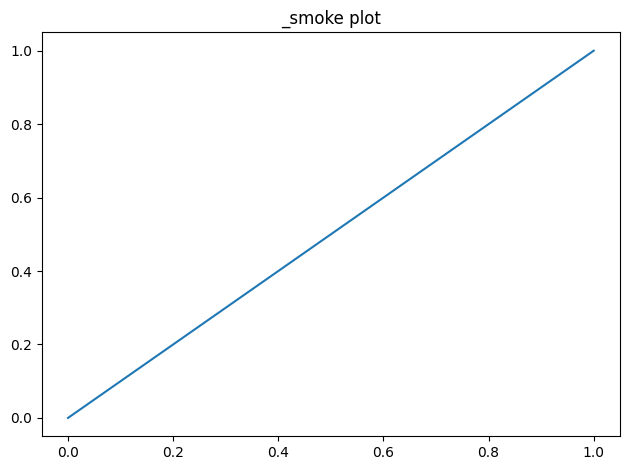

In [2]:
# Smoke test: ensure figure can be saved to repo-local path without errors
from pathlib import Path
import os
import matplotlib.pyplot as plt
out_dir = Path(os.getenv("BSDE_OUT", "tmp_art/Zhang/Results"))
out_dir.mkdir(parents=True, exist_ok=True)
plt.figure(); plt.plot([0,1],[0,1]); plt.title("_smoke plot"); plt.tight_layout()
plt.savefig(out_dir / "_smoke.png")
print(f"Saved smoke figure to: {out_dir / '_smoke.png'}")

In [3]:
# Quick self-check: confirm shapes align for aggregation
try:
    # Only run if previous cell defined res and we can introspect via local computation
    # Recompute a tiny panel to just verify broadcasting works without heavy runtime
    def _mini_shapes():
        _params, _a = params, a
        out = simulate_panel(_params, _a, T=fast(36, 24), N=fast(400, 200), seed=123)
        # Inspect lengths via arrays already returned
        R_mkt = out['R_mkt']
        # Echo size
        print(f"R_mkt length: {len(R_mkt)}; sample mean={float(np.mean(R_mkt)):.4e}")
        return True
    ok = _mini_shapes()
    print("[Self-check] Broadcasting alignment OK" if ok else "[Self-check] Skipped")
except Exception as e:
    print("[Self-check] Skipped due to error:", e)

R_mkt length: 22; sample mean=-1.0415e-01
[Self-check] Broadcasting alignment OK
